In [108]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pyAgrum as gum
import pyAgrum.lib.explain as explain
from sklearn.dummy import DummyClassifier
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn_vs_bn as bnvsbn
import pyAgrum.lib.image as gimg
import graphviz

In [109]:
df = pd.read_csv('https://raw.githubusercontent.com/ImagineDogs/TranstornosMentais/main/dados/df_cid10.csv')
diagnosticos = df[['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo',
                        'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes', 'doenca_infecto']].loc[~df['cid10_faixa'].isnull()]
diagnosticos = diagnosticos.fillna('Sem')

In [110]:
df_train, df_test = train_test_split(diagnosticos, train_size = 0.8, random_state=42)

# Construção da Rede Bayesiana

Nesta etapa, estamos iniciando a construção das redes bayesianas em nosso conjunto de dados. O objetivo é definir as variáveis que serão utilizadas para a análise. No caso, optamos por incluir comorbidades, os dois diagnósticos de entrada e o primeiro diagnóstico de saída.

## Modelo de Rede Bayesiana

Para isso foi utilizada a biblioteca pyAgrum para criar um modelo da rede bayesiana chamado `template`. Este modelo ainda não contém as relações entre as variáveis, sendo apenas uma estrutura inicial.

## Variáveis Definidas

As variáveis escolhidas para análise são as seguintes:
- `cid10_faixa`
- `cid10_faixa_alta`
- `cid10_seg_faixa`
- `sexo`
- `faixa_etaria`
- `etnia`
- `qtd_internacoes`
- `traumatismo`
- `prob_respiratorios`
- `avc`
- `convulsao`
- `has`
- `gravidez`
- `diabetes`

Cada variável é adicionada ao modelo, sendo classificada como inteira ou categórica, conforme a natureza dos dados.

Este é apenas o início do processo, e as relações entre as variáveis serão adicionadas posteriormente.


In [111]:
# Faltou a variável "doenca_infecto"
template = gum.BayesNet('Plus')
labels = ['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo', 'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes']
for i in labels:
  if diagnosticos[i].dtypes == 'int64':
    template.add(gum.IntegerVariable(i, f"{i}", diagnosticos[i].unique().tolist()))
  else:
    template.add(gum.LabelizedVariable(i, f"{i}", diagnosticos[i].unique().tolist()))
template

(pyAgrum.BayesNet<double>@000001BE8F7C8900) BN{nodes: 14, arcs: 0, domainSize: 10^9.85975, dim: 79, mem: 744o}

In [112]:
print(template)

BN{nodes: 14, arcs: 0, domainSize: 10^9.85975, dim: 79, mem: 744o}


In [113]:
gimg.export(template,"template.pdf")

## Naive Bayes sem dados de treino

Para iniciar as definições de conexões, estamos construindo um modelo de rede bayesiana com base na premissa "ingênua" do Naive Bayes. Nesta abordagem, assume-se que as variáveis são condicionalmente independentes entre si, dado o conhecimento das classes.

In [114]:
labels2 = labels.copy()
labels2.remove('cid10_faixa_alta')

In [115]:
alta = ''
for j in diagnosticos['cid10_faixa_alta'].unique():
  alta += '|' + str(j)
alta = 'cid10_faixa_alta{' + alta[1:] + '}'

conections = ''
for i in labels2:
  label = ''
  for j in diagnosticos[i].unique():
    label += '|' + str(j)
  label = i + '{' + label[1:] + '}'

  conections += f'{label}<-{alta};'
bn=gum.fastBN(conections)
gnb.showBN(bn)

In [116]:
gimg.export(bn,"bn.pdf")

## Naive Bayes com dados de treino

Neste trecho, estimamos os parâmetros da rede com base nos dados de treinamento e na estrutura da rede fornecida acima.

In [117]:
learner = gum.BNLearner(df_train, bn)
bn1 = learner.learnParameters(bn.dag())
bn1

(pyAgrum.BayesNet<double>@000001BE8F7CA040) BN{nodes: 14, arcs: 13, domainSize: 10^9.85975, dim: 827, mem: 7Ko 704o}

In [118]:
gimg.export(bn1,"bn1.pdf")

## Rede encontrada a partir dos dados de treino

Neste ponto, realizamos a estimativa dos parâmetros de uma nova rede bayesiana utilizando o conjunto de treinamento . É importante destacar que, nesse caso, a rede bayesiana foi construída sem conexões prévias, sendo totalmente baseada nos dados disponíveis.


In [119]:
learner = gum.BNLearner(df_train, template)
bn2 = learner.learnBN()
bn2

(pyAgrum.BayesNet<double>@000001BE8F7C37A0) BN{nodes: 14, arcs: 12, domainSize: 10^9.85975, dim: 377, mem: 3Ko 608o}

In [120]:
gimg.export(bn2,"bn2.pdf")

## Rede encontrada a partir dos dados de treino, com conexões obrigatórias

Neste trecho, construímos uma nova rede bayesiana utilizando o conjunto de treinamento . No entanto, diferentemente da rede anterior, foram adicionadas conexões prévias manualmente usando o método `addMandatoryArc`. Este procedimento permite incorporar conhecimento prévio na estrutura da rede, ajustando-a de acordo com informações externas.


In [121]:
learner = gum.BNLearner(df_train, template)
learner.addMandatoryArc('cid10_seg_faixa', 'cid10_faixa_alta')
learner.addMandatoryArc('sexo', 'cid10_faixa_alta')
learner.addMandatoryArc('cid10_faixa', 'cid10_faixa_alta')

bn4 = learner.learnBN()
bn4

(pyAgrum.BayesNet<double>@000001BE8F7C2630) BN{nodes: 14, arcs: 13, domainSize: 10^9.85975, dim: 4590, mem: 39Ko 376o}

In [122]:
gimg.export(bn4,"bn4.pdf")

# Classificador

Nesta seção, procederemos com a construção e treinamento dos modelos classificatórios, utilizando os conjuntos de treinamento e teste preparados a seguir.

In [123]:
import pyAgrum.skbn as skbn

In [124]:
y_train = df_train['cid10_faixa_alta']
X_train = df_train.drop(['cid10_faixa_alta'], axis=1)
y_test = df_test['cid10_faixa_alta']
X_test = df_test.drop(['cid10_faixa_alta'], axis=1)

In [125]:
scoreAll = pd.DataFrame()

## Naive Bayes sem dados de treino

Neste trecho, utilizamos a abordagem do Naive Bayes sem treinamento para realizar a classificação. Isso significa que a estrutura da rede bayesiana foi definida sem a utilização de dados de treinamento específicos. O desempenho do modelo foi avaliado, resultando em uma taxa de acerto de 5.66%.


In [126]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Naive Bayes sem treinamento'] = pd.Series(scoreCSV1)

Binary classifier : False


predicted : ['F99-F99', 'F50-F59', 'F99-F99', 'F40-F49', 'F50-F59', 'F60-F69', 'F50-F59', 'F40-F49', 'F20-F29', 'F60-F69', 'F70-F79', 'F50-F59', 'F99-F99', 'F70-F79', 'F20-F29', 'F60-F69', 'F99-F99', 'F60-F69', 'F70-F79', 'F50-F59', 'F60-F69', 'F70-F79', 'F50-F59', 'F60-F69', 'F99-F99', 'F10-F19', 'F60-F69', 'F50-F59', 'F80-F89', 'F90-F98', 'F70-F79', 'F50-F59', 'F70-F79', 'F50-F59', 'F20-F29', 'F70-F79', 'F60-F69', 'F40-F49', 'F99-F99', 'F50-F59', 'F99-F99', 'F70-F79', 'F60-F69', 'F50-F59', 'F70-F79', 'F10-F19', 'F50-F59', 'F50-F59', 'F99-F99', 'F50-F59', 'F40-F49', 'F50-F59', 'F70-F79', 'F70-F79', 'F40-F49', 'F20-F29', 'F99-F99', 'F80-F89', 'F40-F49', 'F20-F29', 'F50-F59', 'F99-F99', 'F99-F99', 'F99-F99', 'F50-F59', 'F99-F99', 'F20-F29', 'F60-F69', 'F50-F59', 'F20-F29', 'F99-F99', 'F99-F99', 'F20-F29', 'F60-F69', 'F50-F59', 'F70-F79', 'F60-F69', 'F99-F99', 'F50-F59', 'F70-F79', 'F10-F19', 'F50-F59', 'F80-F89', 'F60-F69', 'F20-F29', 'F40-F49', 'F60-F69', 'F20-F29', 'F40-F49', 'F20-F29

## Naive Bayes com dados de treino

Utilizando a rede bayesiana baseada no modelo Naive Bayes e parâmetros aprendidos a partir dos dados de treinamento, alcançamos uma taxa de acerto de 70.56%.

In [127]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn1,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Naive Bayes com treinamento'] = pd.Series(scoreCSV1)

Binary classifier : False


predicted : ['F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F90-F98', 'F20-F29', 'F60-F69', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'Sem', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F40-F49', 'F20-F29', 'F30-F39', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F40-F49', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', '

## Rede Bayesiana sem conexões obrigatórias

Ao utilizar a rede bayesiana sem conexões prévias e aprendida a partir dos dados de treinamento, alcançamos uma taxa de acerto de 73.78%.


Binary classifier : False


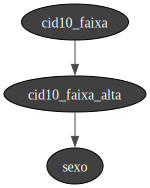

predicted : ['F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F70-F79', 'F20-F29', 'F60-F69', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F60-F69', 'F20-F29', 'F20-F29', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F40-F49', 'F20-F29', 'F20-F29', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F40-F49', 'F10-F19', 'F20-F29', 'F30-F39', 'F70-F79', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39

In [128]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn2,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Rede encontrada pelo treinamento'] = pd.Series(scoreCSV1)

## Rede Bayesiana com conexões obrigatórias

Já utilizando a rede bayesiana com conexões prévias e aprendida a partir dos dados de treinamento, alcançamos uma taxa de acerto de 74.09%.


Binary classifier : False


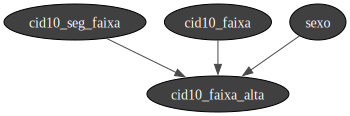

predicted : ['F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F20-F29', 'F20-F29', 'F70-F79', 'F20-F29', 'F60-F69', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F10-F19', 'F20-F29', 'F60-F69', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F20-F29', 'F10-F19', 'F60-F69', 'F20-F29', 'F20-F29', 'F10-F19', 'F20-F29', 'F10-F19', 'F20-F29', 'F40-F49', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F40-F49', 'F20-F29', 'F20-F29', 'F20-F29', 'F60-F69', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F40-F49', 'F10-F19', 'F20-F29', 'F30-F39', 'F70-F79', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F30-F39', 'F30-F39

In [129]:
Redebnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn4,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.to_list()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll['Rede encontrada pelo treinamento, com conexões obrigatórias'] = pd.Series(scoreCSV1)

## Resultados

Ao avaliar o desempenho das redes Bayesianas, notamos que aquela com conexões prévias, aprendida durante o treinamento, obteve o melhor resultado. No entanto, é interessante destacar que a rede sem conexões obrigatórias também apresentou um desempenho muito próximo, indicando uma boa capacidade de aprendizado mesmo sem restrições específicas na estrutura.

In [130]:
scoreAll

Naive Bayes sem treinamento  Naive Bayes com treinamento  \
0                     0.056569                     0.705596   

   Rede encontrada pelo treinamento  \
0                          0.737835   

   Rede encontrada pelo treinamento, com conexões obrigatórias  
0                                           0.740876

## Inferências

 Nesta seção, exploraremos o processo de inferência nas redes bayesianas desenvolvidas anteriormente.

In [131]:
# Esta função recebe um grafo e um ID de nó como entrada e retorna o nome associado ao ID no grafo.
def NameFromId(graph, id):
    node = graph.variable(id)
    return node.name()

In [132]:
def search(graph, top, bottom):
    topfound = []
    pathfound = []
    flag = False

    # Pega todos os pais do nó dado
    parent = graph.parents(bottom)

    # Caso não possua pais e o nó é encontrado
    if parent == set() and bottom in top:
        return [], [bottom], True

    # Caso não possua pais e o nó não é encontrado
    elif parent == set() and bottom not in top:
        return [], [], False

    # Caso possua pais
    elif parent != set():

        # Caso o nó seja encontrado
        if bottom in top:
            topfound = set([bottom]) | set(topfound)
            flag = True

        # Continua a busca para os pais do nó encontrado
        i = 0
        for node in parent:

            i += 1
            auxpath, auxtop, flag2 = search(graph, top, node)

            # Monta o caminho seguido
            pathfound = set(auxpath) | set(pathfound)

            # Se o nó em especifico fizer parte do caminho de um nó encontrado ele é contabilizado no caminho
            if flag2:
                pathfound = set(pathfound) | set([node])

            topfound = set(auxtop) | set(topfound)

        if flag2:
            flag = True
        return pathfound, topfound, flag
    print('d')
    return pathfound, topfound, flag

In [133]:
# Esta função cria um subgrafo a partir de um rede passada como argumento
def subgraph(graph, top=[], bottom = None):
    if type(graph) == gum.BayesNet:
        g_aux = gum.BayesNet(graph)

        top = list(map(g_aux.idFromName, top))
        bottom = g_aux.idFromName(bottom)
        if bottom == None:
            return 'Colocar último'

        # Encontra os ids validos para subgrafo
        id_nos_validos = search(g_aux, top, bottom)[0]
        id_nos_validos = list(id_nos_validos)
        id_nos_validos.extend([bottom])

        nome_nos_validos = list(map(NameFromId, [g_aux]*len(id_nos_validos), id_nos_validos))

        # Criacao do subgrafo
        eliminar = set(g_aux.names()).difference(set(nome_nos_validos))
        for node in eliminar:
            g_aux.erase(node)
        return g_aux

    else:
        print('Passar Rede Bayesiana')


In [134]:
# Esta função realiza inferências em um grafo reduzido
# Parametros:
#   Grafo: Grafo a ser utilizado na inferencia
#   Evs: Eventos a serem inferenciados. Molde -> {Variavel, ValorAssumido}
#   Nó Investigado: Nó alvo para ser investigado (Último)
def inferencia(graph, evs, no_investigado):
    topos = evs.keys()
    graph = subgraph(graph, topos, no_investigado)
    inf = gnb.getInference(graph, evs = evs)
    return inf

### Rede com conexões obrigatórias

In [135]:
# Analisando o impacto do sexo no diagnóstico

inf1 = inferencia(bn4, evs = {'sexo': 'M'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn4, evs = {'sexo': 'F'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn4, evs = {'sexo': 'T'}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3)

In [136]:
gnb.flow.row(gnb.getInference(bn4, evs = {'sexo': 'F'}))

In [137]:
# Analisando o impacto da hipertensão arterial sistêmica (has) no diagnóstico

inf1 = inferencia(bn4, evs = {'has': 'NAO'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn4, evs = {'has': 'SIM'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn4, evs = {'has': 'NAO INFORMADO'}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3)

In [138]:
# Analisando o impacto de problemas respiratórios no diagnóstico

inf1 = inferencia(bn4, evs = {'prob_respiratorios': 'NAO'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn4, evs = {'prob_respiratorios': 'SIM'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn4, evs = {'prob_respiratorios': 'NAO INFORMADO'}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3)

In [139]:
# Analisando o impacto conjunto de problemas respiratórios e hipertensão arterial sistêmica (has) no diagnóstico

inf1 = inferencia(bn4, evs = {'prob_respiratorios': 'NAO', 'has': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn4, evs = {'prob_respiratorios': 'NAO', 'has': "SIM"}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn4, evs = {'prob_respiratorios': 'SIM', 'has': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf4 = inferencia(bn4, evs = {'prob_respiratorios': 'SIM', 'has': "SIM"}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3, inf4)

In [140]:
# Analisando o impacto do traumatismo no diagnóstico

inf1 = inferencia(bn4, evs = {'traumatismo': 'NAO'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn4, evs = {'traumatismo': 'SIM'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn4, evs = {'traumatismo': 'NAO INFORMADO'}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3)

In [141]:
# Analisando o impacto conjunto de traumatismo e problemas respiratórios no diagnóstico

inf1 = inferencia(bn4, evs = {'traumatismo': 'NAO', 'prob_respiratorios': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn4, evs = {'traumatismo': 'NAO', 'prob_respiratorios': "SIM"}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn4, evs = {'traumatismo': 'SIM', 'prob_respiratorios': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf4 = inferencia(bn4, evs = {'traumatismo': 'SIM', 'prob_respiratorios': "SIM"}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3, inf4)

In [142]:
# Analisando o impacto conjunto de traumatismo e hipertensão arterial sistêmica (has) no diagnóstico

inf1 = inferencia(bn4, evs = {'traumatismo': 'NAO', 'has': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn4, evs = {'traumatismo': 'NAO', 'has': "SIM"}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn4, evs = {'traumatismo': 'SIM', 'has': "NAO"}, no_investigado = 'cid10_faixa_alta')
inf4 = inferencia(bn4, evs = {'traumatismo': 'SIM', 'has': "SIM"}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3, inf4)

## Treinando uma rede com arcos aleatorios a partir do modelo fixo Naive Bayes

Nesta seção, abordaremos o treinamento de uma rede bayesiana com a introdução de novos arcos, mantendo o modelo Naive Bayes como base.


No entanto, dada a alta complexidade computacional envolvida no processo de encontrar novos arcos aleatórios, especialmente quando alguns já estão fixados, será necessário restringir o escopo das fixações.

In [143]:
learner = gum.BNLearner(df_train, template)
for i in labels2[:-4]: # restringindo o escopo das fixações
    learner.addMandatoryArc(i, 'cid10_faixa_alta')
bn5 = learner.learnBN()
bn5

(pyAgrum.BayesNet<double>@000001BE8F7CB780) BN{nodes: 14, arcs: 19, domainSize: 10^9.85975, dim: 122904774, mem: 1022Mo 956Ko 184o}

In [144]:
# Analisando o impacto de problemas respiratórios no diagnóstico

inf1 = inferencia(bn5, evs = {'prob_respiratorios': 'SIM'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn5, evs = {'prob_respiratorios': 'NAO'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn5, evs = {'prob_respiratorios': 'NAO INFORMADO'}, no_investigado = 'cid10_faixa_alta')

gnb.flow.row(inf1, inf2, inf3)

In [164]:
inf1 = inferencia(bn5, evs = {'faixa_etaria': '20-29'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn5, evs = {'cid10_faixa': 'F60-F69'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn5, evs = {'faixa_etaria': '20-29', 'cid10_faixa': 'F60-F69'}, no_investigado = 'cid10_faixa_alta')

gnb.flow.row(inf1, inf2, inf3)

# Árvore de decisão como guia para a rede bayesiana

Nesta seção, utilizaremos uma árvore de decisão como guia para a construção de uma rede bayesiana. A ideia é explorar a estrutura aprendida pela árvore de decisão e utilizá-la como ponto de partida para o treinamento da rede bayesiana. A árvore de decisão oferece uma clareza maior sobre a importância e relacionamentos entre as variáveis, que podem ser incorporados ao modelo bayesiano.


In [146]:
labels = ['cid10_faixa', 'cid10_faixa_alta', 'cid10_seg_faixa', 'sexo', 'faixa_etaria', 'etnia', 'qtd_internacoes', 'traumatismo', 'prob_respiratorios', 'avc', 'convulsao', 'has','gravidez', 'diabetes', 'doenca_infecto']

labels2 = labels.copy()
labels2.remove('cid10_faixa_alta')

In [147]:
df_train, df_test = train_test_split(diagnosticos, train_size = 0.8, random_state=36)

In [148]:
y_train = df_train['cid10_faixa_alta']
X_train = df_train.drop(['cid10_faixa_alta'], axis=1)
y_test = df_test['cid10_faixa_alta']
X_test = df_test.drop(['cid10_faixa_alta'], axis=1)

Antes de iniciar a construção da árvore de decisão, é essencial realizar a transformação dos dados utilizando um encoder adequado. Neste caso, optamos pelo OneHotEncoder, uma vez que as categorias são independentes e não possuem uma ordem específica. Este encoder transforma cada categoria em uma coluna de valores binários.

In [149]:
from sklearn.preprocessing import OneHotEncoder

encX = OneHotEncoder()

X_train_encoded = encX.fit_transform(X_train)
X_test_encoded = encX.transform(X_test)
y_train, y_test = y_train.values, y_test.values
X_train_encoded, X_test_encoded, = X_train_encoded.toarray(), X_test_encoded.toarray()

In [150]:
X_train_encoded

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [151]:
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(6574, 84)
(1644, 84)


In [152]:
# Esta função avalia o desempenho do modelo, retornando a acurácia e a F1 Score
def evaluate(y_pred, y_test):
    acuracia = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test, average='weighted')

    print('Resultados:')
    print(f'    Acuracia: {acuracia}')
    print(f'    F1: {f1}')
    return acuracia, f1

## Construção da Árvore

Para melhorar o desempenho da Árvore de Decisão, empregamos a técnica de GridSearch, em busca de encontrar os melhores parâmetros para o modelo.

In [153]:
tc = DecisionTreeClassifier(random_state=42)
param_tc = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': range(5, 20, 1)}

gs_tc = GridSearchCV(tc, param_tc, cv=5, scoring='f1_weighted')

best_model = gs_tc.fit(X_train_encoded, y_train)
print(best_model.best_params_)

{'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'}


In [154]:
labels2

['cid10_faixa',
 'cid10_seg_faixa',
 'sexo',
 'faixa_etaria',
 'etnia',
 'qtd_internacoes',
 'traumatismo',
 'prob_respiratorios',
 'avc',
 'convulsao',
 'has',
 'gravidez',
 'diabetes',
 'doenca_infecto']

In [155]:
model = DecisionTreeClassifier(random_state=42, criterion=best_model.best_params_['criterion'], max_depth=best_model.best_params_['max_depth'], splitter=best_model.best_params_['splitter'])
model.fit(X_train_encoded, y_train)
df2 = pd.DataFrame(encX.inverse_transform(X_train_encoded), columns=labels2)

labels3 = []
for i in labels2:
  labels3.extend(df2[i].apply(lambda x: i + '_' + str(x)).unique().tolist())
labels3

dot_data = export_graphviz(model, out_file=None,
                           feature_names=labels3,
                           class_names=np.unique(y_train).tolist(),
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("iris_tree")

'iris_tree.pdf'

In [156]:
y_pred = best_model.predict(X_test_encoded)
acuracia_dt, f1_dt = evaluate(y_pred, y_test)

Resultados:
    Acuracia: 0.7299270072992701
    F1: 0.7414685979309048


## Utilização da Árvore para a criação da Rede Bayesiana

In [157]:
template = gum.BayesNet('Plus')
for i in labels:
  if diagnosticos[i].dtypes == 'int64':
    template.add(gum.IntegerVariable(i, f"{i}", diagnosticos[i].unique().tolist()))
  else:
    template.add(gum.LabelizedVariable(i, f"{i}", diagnosticos[i].unique().tolist()))
template

(pyAgrum.BayesNet<double>@000001BE8F7C3D70) BN{nodes: 15, arcs: 0, domainSize: 10^10.3369, dim: 81, mem: 768o}

Neste trecho, estamos construindo uma nova rede bayesiana a partir de algumas conexões pressupostas a partir da árvore de decisão aprendida.

In [158]:
# A partir da árvore de decisão é possível pressupor algumas conexões entre variáveis

learner = gum.BNLearner(df_train, template)
learner.addMandatoryArc('cid10_faixa', 'cid10_seg_faixa') # Exemplos
learner.addMandatoryArc('cid10_seg_faixa', 'qtd_internacoes')
learner.addMandatoryArc('cid10_seg_faixa', 'cid10_faixa_alta')
learner.addMandatoryArc('sexo', 'cid10_faixa_alta')
bn6 = learner.learnBN()

bn6

(pyAgrum.BayesNet<double>@000001BE8F7C2C00) BN{nodes: 15, arcs: 20, domainSize: 10^10.3369, dim: 5008, mem: 43Ko 368o}

In [159]:
gimg.export(bn6,"b6.pdf")

Utilizando a rede bayesiana baseada na árvore de decisão e aprendida a partir dos dados de treinamento, alcançamos uma taxa de acerto de 73.60%.

Binary classifier : False


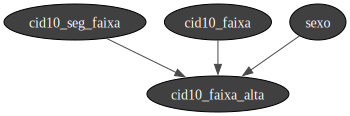

predicted : ['F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F10-F19', 'F20-F29', 'F20-F29', 'F30-F39', 'F10-F19', 'F70-F79', 'F10-F19', 'F60-F69', 'F30-F39', 'F10-F19', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F01-F09', 'F20-F29', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F30-F39', 'F10-F19', 'F60-F69', 'F30-F39', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F60-F69', 'F30-F39', 'F10-F19', 'F20-F29', 'F20-F29', 'F20-F29', 'F30-F39', 'F70-F79', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F20-F29', 'F10-F19', 'F30-F39', 'F60-F69', 'F10-F19', 'F20-F29', 'F40-F49', 'F20-F29', 'F70-F79', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F30-F39', 'F30-F39', 'F10-F19', 'F10-F19', 'F30-F39', 'F20-F29', 'F30-F39', 'F10-F19', 'F10-F19', 'F20-F29', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F30-F39', 'F20-F29', 'F10-F19', 'F10-F19', 'F10-F19', 'F30-F39', 'F10-F19', 'F10-F19', 'F10-F19

In [160]:
bnc=skbn.BNClassifier()
bnc.fromTrainedModel(bn6,targetAttribute="cid10_faixa_alta")
print(f"Binary classifier : {bnc.isBinaryClassifier}")
gnb.showBN(bnc.MarkovBlanket)
print(f"predicted : {list(bnc.predict(X_test))}")
print(f"in base   : {y_test.tolist()}")
scoreCSV1 = bnc.score(X_test, y = y_test)
print("{0:.2f}% good predictions".format(100*scoreCSV1))
scoreAll["Rede encontrada utilizando a estrutura do naive bayes não fixada"] = pd.Series(scoreCSV1)

In [161]:
#  Analisando o impacto do sexo no diagnóstico

inf1 = inferencia(bn6, evs = {'sexo': 'M'}, no_investigado = 'cid10_faixa_alta')
inf2 = inferencia(bn6, evs = {'sexo': 'F'}, no_investigado = 'cid10_faixa_alta')
inf3 = inferencia(bn6, evs = {'sexo': 'T'}, no_investigado = 'cid10_faixa_alta')
gnb.flow.row(inf1, inf2, inf3)